In [32]:

import os
import time
import itertools
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

'''
Can we predict the programming language given the Title and the body

Is there a corallation between title length, body length and creation date between rating?
Can we predict the quality rating of a stack over flow question?

creation_date_sanitized = np.array([int(datetime.strptime(date, '%Y-%m-%d %H:%M:%S').timestamp()) for date in data['CreationDate']])
data['CreationDate'] = creation_date_sanitized
'''

#We want to be able to predict the tags for a post given the body and title


In [33]:
# ------ EXPLORING THE DATA -------
def tagCounts(data_obj):
    dataTags = data_obj['Tags']
    tagList = []
    
    for i in dataTags:
        tagStr = str(i).replace(">",'').replace("<", ' ').split(" ")
        for tagName in tagStr:
            if tagName != '':
                tagList.append(tagName)
                
    tag_counter = {}
    for tag in tagList:
        if tag in tag_counter:
            tag_counter[tag] +=1
        else:
            tag_counter[tag] = 1
            
    values = []
    for key, value in tag_counter.items():
        values.append(value)
        
    most_common_tags = sorted(tag_counter, key=tag_counter.get, reverse=True)
    top15 = most_common_tags[:15]
    
    super_list = []
    tc_15 = values[:15]
    tn_15 = most_common_tags[:15]

    return sorted(tc_15, reverse=True), tn_15


In [34]:
# ------ EXPLORING THE DATA -------
def getTop15MostCommonTags(data_obj):
    dataTags = data_obj['Tags']
    tagList = []
    
    for i in dataTags:
        tagStr = str(i).replace(">",'').replace("<", ' ').split(" ")
        for tagName in tagStr:
            if tagName != '':
                tagList.append(tagName)
                
    tag_counter = {}
    for tag in tagList:
        if tag in tag_counter:
            tag_counter[tag] +=1
        else:
            tag_counter[tag] = 1
            
    most_common_tags = sorted(tag_counter, key=tag_counter.get, reverse=True)
    return most_common_tags[:15]

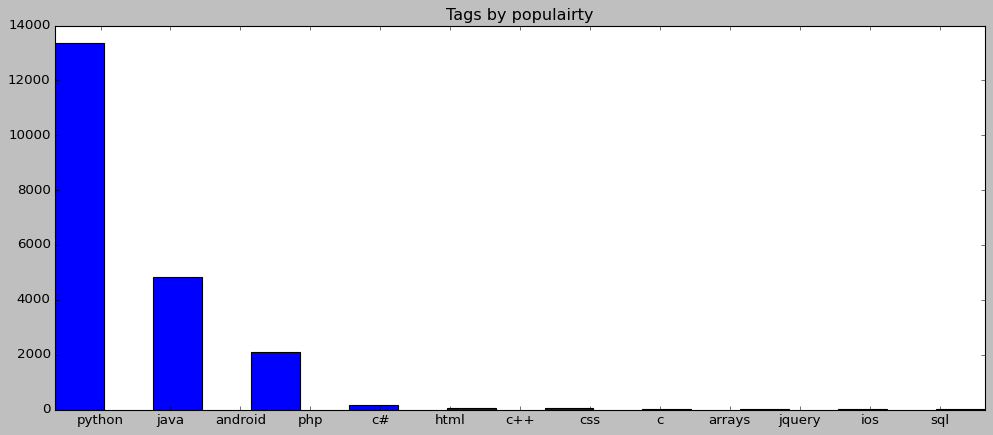

In [35]:
trainData = pd.read_csv('train.csv')
validData = pd.read_csv('valid.csv')

frames = [trainData, validData]
data = pd.concat(frames)

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(itertools.islice(iterable, n))

mostCommonTags = getTop15MostCommonTags(data)
tc = tagCounts(data)
test_values = tc[0]
test_keys = tc[1]

res = {} 
for key in test_keys: 
    for value in test_values: 
        res[key] = value 
        test_values.remove(value) 
        break

data = data.drop(['Id'], axis=1)
data = data.drop(['Tags'], axis=1)

'''
The preprocessing that follows was used as our inital route of exploration for the data set,
we left it in, because much like the machines we are training to learn - we too are learning.

'''

# ------ OLD PREPROCESSING START ------

ls = []
titleStr = data['Title']
qChecklst = np.array([])
contains_question_mark = np.array([ ls.append(1) if '?' in i else ls.append(0) for i in titleStr])
data['Contains_Question'] = ls

title_data_sanitzed = np.array([len(i) - i.count(" ") for i in data['Title']])
data['Title'] = title_data_sanitzed
body_data_sanitized = np.array([len(i) - i.count(" ") for i in data['Body']])
data['Body'] = body_data_sanitized

creation_date_sanitized = np.array([datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in data['CreationDate']])
data['CreationDate'] = creation_date_sanitized

data['Creation_Day'], data['Creation_Month'], data['Creation_Year'] = data['CreationDate'].dt.day, data['CreationDate'].dt.month, data['CreationDate'].dt.year
data['Creation_Hour'], data['Creation_Minute'] =  data['CreationDate'].dt.hour,  data['CreationDate'].dt.minute
data = data.drop(['CreationDate'], axis=1)

# ------ OLD PREPROCESSING END ------


In [36]:
#  ------ EXPLORING THE DATA -------
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
quality_cat = data["Y"]
quality_cat_encoded = encoder.fit_transform(quality_cat)
data["Y"] = quality_cat_encoded
print(encoder.classes_)

['HQ' 'LQ_CLOSE' 'LQ_EDIT']


In [37]:

# ------ EXPLORING THE DATA -------
def exploringTheData_Part1():
    #Select all 2016 questions. we want to know of the 2016 year how many questions has a rating of HQ?
    years = [2020, 2016]
    for year in years:
        select_date = data.loc[data['Creation_Year'] == year]
        plt.hist(select_date['Y'], color='r', label="{} number of ratings ".format(str(year)))
        plt.xticks(ticks=[0,1,2], labels=["HQ","LQ_CLOSE","LQ_EDIT"])
        plt.xlabel("Rating")
        plt.title("Rating Count {}".format(str(year)))
        plt.ylabel("Number of ratings")
        plt.savefig("D:\\INFR3600-Final-Project\\hist_rating_count_{}.png".format(str(year)))
        plt.xlim(0,2.1)
        plt.legend()
        #plt.savefig("D:\\INFR3600-Final-Project\\hist_rating_count_{}.png".format(year))
        plt.show()
        
        
    #Which programming languages/tags were most common in year x?
    corr_matrix = data.corr()['Y']
    print(corr_matrix.abs().sort_values(ascending=False))
    max_cor_str = corr_matrix.abs().sort_values(ascending=False).index[1]
    
    plt.scatter(data['Title'], data['Body'], s=2, alpha=0.6)
    plt.xlabel("Title Length")
    plt.ylabel("Body Length")
    plt.title("Body Length vs Title Length")
    plt.savefig("D:\\INFR3600-Final-Project\\blen_vs_tlen.png")
    plt.show()
    
    #get contains question and has HQ rating
    cq_var = data[data['Contains_Question'] == 1].iloc[:,2]
    #get contains question and has LQ rating
    dcq_var= data[data['Contains_Question'] == 0].iloc[:,2]
    
    #of the titles that contain question marks, how many of those are high quality and how many our low quality
    plt.figure(figsize=(10,10))
    
    plt.subplot(2,2,1)
    plt.title("Contains ? and Ratings")
    plt.xticks(ticks=[0,1,2], labels=["HQ","LQ_CLOSE","LQ_EDIT"])
    plt.hist(cq_var)
    
    plt.subplot(2,2,2)
    plt.title("Does not contain ? and Ratings")
    plt.xticks(ticks=[0,1,2] ,labels=["HQ","LQ_CLOSE","LQ_EDIT"])
    plt.hist(dcq_var)
    plt.tight_layout()
    plt.show()

In [38]:
#can we predict the length of a post title given, body length, Creation Day and Rating?
corr_matrix = data.corr()['Creation_Year']
print(corr_matrix.abs().sort_values(ascending=False))
max_cor_str = corr_matrix.abs().sort_values(ascending=False).index[1]
print(data.head())

Creation_Year        1.000000
Y                    0.151731
Creation_Month       0.102814
Title                0.067942
Contains_Question    0.024322
Body                 0.007738
Creation_Day         0.006339
Creation_Hour        0.002103
Creation_Minute      0.000760
Name: Creation_Year, dtype: float64
   Title  Body  Y  ...  Creation_Year  Creation_Hour  Creation_Minute
0     33   259  1  ...           2016              0               21
1     29    95  0  ...           2016              2                3
2     46  3575  0  ...           2016              2               48
3     35   584  0  ...           2016              3               30
4     30   357  0  ...           2016              5               21

[5 rows x 9 columns]


       Title  Body  Y  ...  Creation_Day  Creation_Hour  Creation_Minute
11176     40   139  0  ...            26             17               24
8846      39   418  2  ...             3              9               36
40008     44  4353  2  ...            26              6               36
8025      40  1952  0  ...            11              8               36
665       35  1111  1  ...            10              7                9

[5 rows x 7 columns]
Epoch 1/10
938/938 [==============================] - 2s 2ms/step - loss: 629.3441 - mse: 629.3441 - val_loss: 342.6436 - val_mse: 342.6436
Epoch 2/10
938/938 [==============================] - 2s 2ms/step - loss: 350.2572 - mse: 350.2572 - val_loss: 342.6707 - val_mse: 342.6707
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 350.2672 - mse: 350.2672 - val_loss: 342.5394 - val_mse: 342.5394
Epoch 4/10
938/938 [==============================] - 2s 2ms/step - loss: 350.2813 - mse: 350.2813 - val_loss: 342.5834 

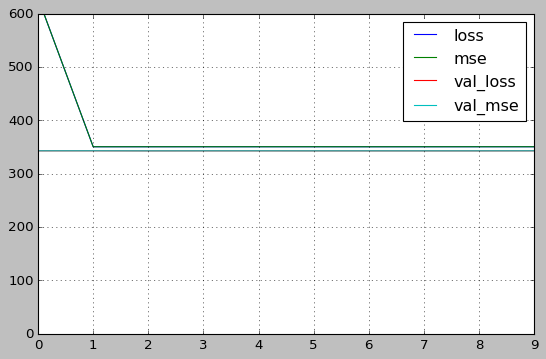

In [39]:
#Our really poor initial Deep Neural network, using bogus values
def predictingCreationyear(data):
    import keras.optimizers
    #Train a model and see if we can predict the length of a body
    train, test = train_test_split(data, test_size=0.5, random_state=42)

    train_data = train.drop(['Creation_Year','Creation_Month'], axis=1)
    train_labels = train.iloc[:,0]

    test_data = test.drop(['Creation_Year','Creation_Month'], axis=1)
    test_labels = test.iloc[:,0]

    print(train_data.head())

    from sklearn.preprocessing import StandardScaler
    scaler=StandardScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(train_data)

    from tensorflow import keras
    model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[7]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(90, activation="relu", kernel_initializer="HeNormal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1)
    ])

    #opt = keras.optimizers.RMSprop(learning_rate=0.01,
      #rho=0.09,
       #momentum=0.1,
        #epsilon=1e-07)
    opt = tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.2, nesterov=False, name="SGD")

    model.compile(loss="mse", 
    optimizer=opt,
    metrics=["mse"])

    history = model.fit(train_data, train_labels, epochs=10, validation_data=(test_data, test_labels), verbose=1)# Turn verbose=1 to printing epochs

    import matplotlib.pyplot as plt
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 600)
    plt.show()

predictingCreationyear(data)

In [41]:

trainData = pd.read_csv('train.csv')
validData = pd.read_csv('valid.csv')

frames = [trainData, validData]
data = pd.concat(frames)

data = data.drop(['Id', 'Tags', 'CreationDate'], axis=1)
data['Y'] = data['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})
data.head()



,Title,Body,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,0
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,2
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,2
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",2
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,2


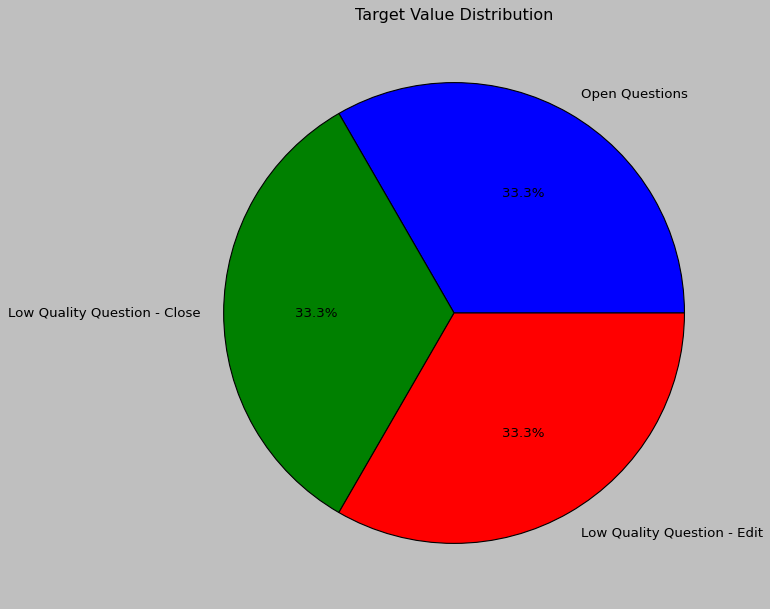

In [42]:
labels = ['Open Questions', 'Low Quality Question - Close', 'Low Quality Question - Edit']
values = [len(data[data['Y'] == 2]), len(data[data['Y'] == 0]), len(data[data['Y'] == 1])]
plt.style.use('classic')
plt.figure(figsize=(16, 9))
plt.pie(x=values, labels=labels, autopct="%1.1f%%")
plt.title("Target Value Distribution")
plt.show()

In [43]:
data['text'] = data['Title'] + ' ' + data['Body']
data = data.drop(['Title', 'Body'], axis=1)
data.head()

,Y,text
0,0,Java: Repeat Task Every Random Seconds <p>I'm ...
1,2,Why are Java Optionals immutable? <p>I'd like ...
2,2,Text Overlay Image with Darkened Opacity React...
3,2,Why ternary operator in swift is so picky? <p>...
4,2,hide/show fab with scale animation <p>I'm usin...


In [44]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^(a-zA-Z)\s]','', text)
    return text

data['text'] = data['text'].apply(clean_text)

split_pcent = 0.20
split = int(split_pcent * len(data))

# Shuffles dataframe
data = data.sample(frac=1).reset_index(drop=True)

# Training Sets
train = data[split:]
trainX = train['text']
trainY = train['Y'].values

# Validation Sets
valid = data[:split]
validX = valid['text']
validY = valid['Y'].values



Training Data Shape: (12000,)
Validation Data Shape: (12000,)


In [45]:
vectorizer = TfidfVectorizer()
trainX = vectorizer.fit_transform(trainX)
validX = vectorizer.transform(validX)

In [68]:
from sklearn.linear_model import LogisticRegression
lr_classifier = LogisticRegression(C=1.)
lr_classifier.fit(trainX, trainY)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [69]:
print(f"Validation Accuracy of Logsitic Regression Classifier is: {(lr_classifier.score(validX, validY))*100:.2f}%")

Validation Accuracy of Logsitic Regression Classifier is: 88.14%


In [67]:
# ------ SGDClassifier ------
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42, max_iter=30, tol=1e-3)
sgd_clf.fit(trainX, trainY)

tag_predictions = sgd_clf.predict(validX)

print(len(tag_predictions))


print(f"Validation Accuracy of SDG: {(sgd_clf.score(validX, validY))*100:.2f}%")

from sklearn.model_selection import cross_val_score
scores = cross_val_score(sgd_clf, trainX, trainY, cv=3, scoring="accuracy")
print('Score for each fold:', scores)

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, trainX, trainY, cv=3)
from sklearn.metrics import confusion_matrix
print('Confusion matrix: [[TN, FP],[FN,TP]', confusion_matrix(trainY, y_train_pred))

print('Classes:', sgd_clf.classes_)

12000
Validation Accuracy of SDG: 86.28%
Score for each fold: [0.847125  0.8483125 0.848625 ]
Confusion matrix: [[TN, FP],[FN,TP] [[11389  2170  2450]
 [   97 15589   313]
 [ 1767   498 13727]]
Classes: [0 1 2]
